In [1]:
from __future__ import division
import requests
import time as t
from mpl_toolkits.basemap import Basemap
from shapely.geometry import mapping, shape
from matplotlib import pyplot as plt
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle
from geojson import LineString, Feature, Point, FeatureCollection, dumps
import itertools
%matplotlib inline
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

# Open Traffic Reporter Validation Service 

### 1. Generate Random Routes from Google Maps API

In [2]:
mapsApiKey = os.environ.get('GOOGLE_MAPS')

In [2]:
# routeList = val.get_POI_routes('San Francisco', 100, mapsApiKey)
routeList = [({"home":{"lat":37.8261, "lon": -122.25872}}, {"work":{"lat":37.790168, "lon":-122.402264}})]

In [3]:
routeList

[({'home': {'lat': 37.8261, 'lon': -122.25872}},
  {'work': {'lat': 37.790168, 'lon': -122.402264}})]

### 2. Iterate through each route, saving results to the ../data/ directory

In [4]:
df = pd.DataFrame(columns=['route','noise','score','route_url','trace_attr_url','reporter_url'])
outDfRow = -1

for i, rteCoords in enumerate(routeList):
    
    print i
    
    stName = rteCoords[0].keys()[0]
    endName = rteCoords[1].keys()[0]
    stLat = rteCoords[0].values()[0]["lat"]
    stLon = rteCoords[0].values()[0]["lon"]
    endLat = rteCoords[1].values()[0]["lat"]
    endLon = rteCoords[1].values()[0]["lon"]
    shape, routeUrl = val.get_route_shape(stLat, stLon, endLat, endLon)
    edges, traceAttrUrl = val.get_trace_attrs(shape)
    
    noiseLevels = np.linspace(0, 0.1, 11)
    scores = []
    
    for noise in noiseLevels:
        
        noise = round(noise,3)
        outDfRow += 1
        routeName = '{0}_to_{1}'.format(stName, endName)
        df.loc[outDfRow, ['route', 'noise','route_url','trace_attr_url']] = [routeName, noise, routeUrl, traceAttrUrl]
        dfEdges = val.format_edge_df(edges)
        jsonDict, geojson = val.synthesize_gps(edges, shape, stddev=noise)
        if jsonDict is None or geojson is None:
            msg = "Trace attributes tried to call more edges than are present in the route shape".format(
            routeName)
            df.loc[outDfRow, ['score', 'reporter_url']] = [None, msg]
            continue
        segments, reportUrl = val.get_reporter_segments(jsonDict)
        if segments is None:
            continue
        elif segments == 0:
            msg = 'Reporter found 0 segments for {0} at noise level {1}'.format(
            routeName, noise)
            df.loc[outDfRow, ['score', 'reporter_url']] = [None, msg]
            continue
        matches, score = val.get_matches(segments, dfEdges)
        df.loc[outDfRow, ['score', 'reporter_url']] = [score, reportUrl]
        
        matches.to_csv(
            '../data/matches_{0}_to_{1}_w_{2}_km_noise.csv'.format(
                stName, endName, str(noise), index=False))
        with open('../data/trace_{0}_to_{1}_w_{2}_km_noise.geojson'.format(
            stName, endName, str(noise)), 'w+') as fp:
            json.dump(geojson, fp)

0


### 3. Plot the results

In [5]:
df['score'] = df['score'].astype(float)

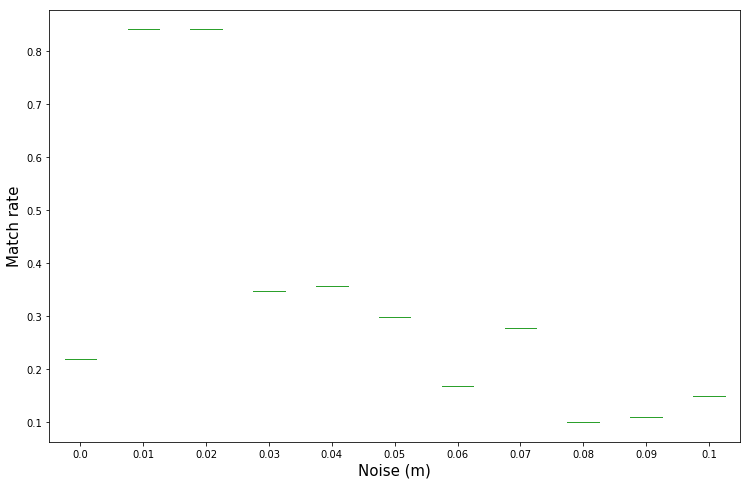

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
df.boxplot(column='score',by='noise', ax=ax, grid=False)
ax.set_xlabel('Noise (m)', fontsize=15)
ax.set_ylabel('Match rate', fontsize=15)
ax.set_title('')
fig.suptitle('')
fig.savefig('./../data/score_vs_noise.png')

### 4. Save the scores

In [7]:
df.columns = [x.strip().replace(' ', '_') for x in df.columns]

In [8]:
# df.to_csv('../data/master_scores.csv', index=False)

### 5. Visualize Routes?

In [5]:
url = "http://stamen-tiles-{s}.a.ssl.fastly.net/toner-lite/{z}/{x}/{y}.png"
provider = TileLayer(url=url, opacity=1)

In [6]:
center = [(stLat + endLat) / 2, (stLon + endLon) / 2]
zoom = 12

In [7]:
m = Map(default_tiles=provider, center=center, zoom=zoom, width='1000px', height='600px' )
m

The installed widget Javascript is the wrong version.


In [8]:
with open("../data/trace_home_to_work_w_0.01_km_noise.geojson", "r") as f:
    data=json.load(f)

In [9]:
g = GeoJSON(data=data)

In [10]:
m.add_layer(g)